In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from numpy.random import default_rng
from graph.structure.graph import Graph
from graph.prior import SparsePrior
from graph.propagator import UnitaryPropagator
from graph.measurement import MaskedGaussianMeasurement
from core.linalg_utils import random_unitary_matrix, random_binary_mask
from core.metrics import mse

# 1. パラメータ設定
n = 512
rho = 0.1          # sparsity
var = 1e-4         # noise variance
mask_ratio = 0.2   # percentage of observed entries

# 2. ユニタリ行列 U の生成
rng = default_rng(seed=123)
U = random_unitary_matrix(n, rng=rng)
mask = random_binary_mask(n, subsampling_rate=mask_ratio, rng = rng)

# 4. グラフ構築
class CompressiveSensingGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = SparsePrior(rho=rho, shape=(n,))
        self.Y = UnitaryPropagator(U) @ self.X
        self.Z = MaskedGaussianMeasurement(self.Y, var=var, mask=mask)
        self.compile()

g = CompressiveSensingGraph()

# 5. RNG設定（初期メッセージとサンプリングを分離）
g.set_init_rng(np.random.default_rng(seed=0))
g.generate_sample(rng=np.random.default_rng(seed=42))

# 6. 真の信号と観測データを取得
true_x = g.X.get_sample()
observed = g.Z.get_sample()

# 7. 推論の実行
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = mse(est, true_x)
    if t % 5 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

g.run(n_iter=30, callback=monitor)

# 8. 最終精度を表示
final_est = g.X.compute_belief().data
print(f"Final MSE after 30 iterations: {mse(final_est, true_x):.5e}")

[t=0] MSE = 3.56369e-01
[t=5] MSE = 4.01079e-02
[t=10] MSE = 1.13759e-02
[t=15] MSE = 1.40098e-03
[t=20] MSE = 1.04197e-04
[t=25] MSE = 9.06127e-05
Final MSE after 30 iterations: 8.73296e-05


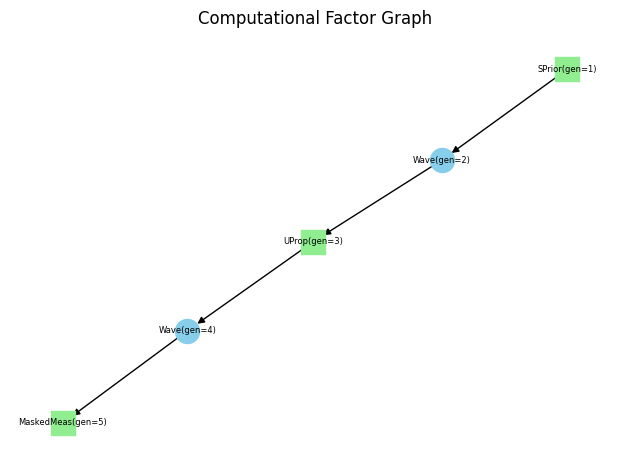

In [3]:
g.visualize(layout="kamada_kawai", font_size=6, scale=2.0)